In [3]:
import numpy as np #python library for working with arrays
import pandas as pd # for working with datasets

#Graphs
import matplotlib.pyplot as plt #visualization
from matplotlib import pyplot #visualization 
%matplotlib inline 
#static images of your plot embedded in the workbook

#For splitting the train and test data
from sklearn.model_selection import train_test_split

#For Sampling
from sklearn.utils import resample

#XGBoost Algorithm
import xgboost as xgb

#Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE

In [4]:
pd.options.display.max_colwidth = 150 #to extend the maximum width of the output display

In [5]:
data = pd.read_csv("./data/aug_train.csv")
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


## Reading the Dataset
**About the Dataset:**

Insurance companies that sell life, health, and property and casualty insurance are using machine learning (ML) to drive improvements in customer service, fraud detection, and operational efficiency. We can build a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

We have information about:

Demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel), etc.

Aim:

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimize its business model and revenue.

Data Source: Kaggle - Learning from Imbalanced Insurance Data.

For more information, refer to: https://www.kaggle.com/datasets/arashnic/imbalanced-data-practice

## Basic Data Preprocessing

In [7]:
data.isnull().sum().sum() #checking for null values

0

In [8]:
data.dtypes #checking the data types of the various columns


id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,382154.0,234392.953477,139527.487326,1.0,115006.25,230461.5,345434.75,508145.0
Age,382154.0,38.545691,15.226897,20.0,25.00,36.0,49.00,85.0
Driving_License,382154.0,0.998108,0.043455,0.0,1.00,1.0,1.00,1.0
Region_Code,382154.0,26.406867,13.181241,0.0,15.00,28.0,35.00,52.0
Previously_Insured,382154.0,0.489182,0.499884,0.0,0.00,0.0,1.00,1.0
Annual_Premium,382154.0,30711.271362,17061.595532,2630.0,24546.00,31692.0,39447.75,540165.0
Policy_Sales_Channel,382154.0,111.939812,54.286511,1.0,26.00,145.0,152.00,163.0
Vintage,382154.0,154.189429,83.735107,10.0,81.00,154.0,227.00,299.0
Response,382154.0,0.163811,0.370104,0.0,0.00,0.0,0.00,1.0


In [11]:
data = pd.get_dummies(data, ['Gender', 'Vehicle_Age', 'Vehicle_Damage']) #one-hot-encoding for Categorical Columns

# Check the Class Imbalance 

In [17]:
data["Response"].value_counts()

0    319553
1     62601
Name: Response, dtype: int64

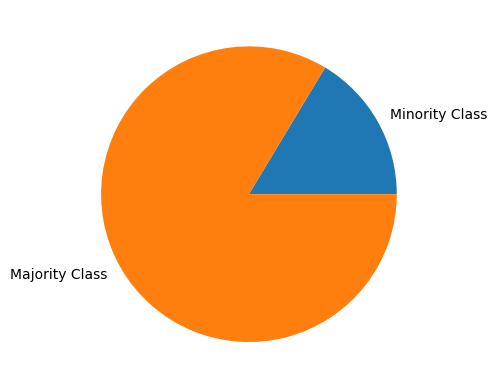

In [19]:
class_division = [data[data["Response"] ==1].shape[0],data[data["Response"] ==0].shape[0]]

my_labels = ["Minority Class","Majority Class"]

plt.pie(class_division, labels=my_labels)
plt.show()

In [20]:
print("Proportion of Minority Class: " + str(round(data[data['Response'] == 1 ].shape[0]/data.shape[0] * 100, 2)) + "%")

Proportion of Minority Class: 16.38%


In [21]:
from sklearn.model_selection import train_test_split #splitting the data into train and test

X = data.drop(columns= ['id', 'Response']) #Columns to be excluded from training set
y = data['Response'] #defining the Response as y

X.columns = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Gender_Female',
       'Gender_Male', 'Vehicle_Age_1_2_Year', 'Vehicle_Age_lessthan_1_Year',
       'Vehicle_Age_greaterthan_2_Years', 'Vehicle_Damage_No', 'Vehicle_Damage_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# splitting the data into train and test. Note that here, we have used stratify = y, so that the class imbalances are properly 
# replicated in our train and test dataset. The data is split in a 70-30 ratio of train:test.

In [22]:
print("Proportion of Minority Class in train set: " + str(round(y_train.sum()/len(y_train) * 100, 2)) + "%")
print("Proportion of Minority Class in test set: " + str(round(y_test.sum()/len(y_test) * 100, 2)) + "%")

Proportion of Minority Class in train set: 16.38%
Proportion of Minority Class in test set: 16.38%


## Building a Basic XGBoost Model
We choose an XGBoost model to illustrate the effect of class imbalance in the data. XGBoost models are usually robust, guard against overfitting and do not adhere to many assumptions as in cases of decision trees or logistic regression models. Here we see that inspite of all these qualities, the xgboost model does not perform well in case of the unbalanced dataset.

In [23]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
test = xgb_classifier.predict(X_test)

Here, we will check the accuracy of the model and see how it compares to the precision, recall and F1 Score.

In [25]:
print("Accuracy of Test Set:", round(accuracy_score(y_test,test) * 100, 2 ), "%")

Accuracy of Test Set: 84.53 %


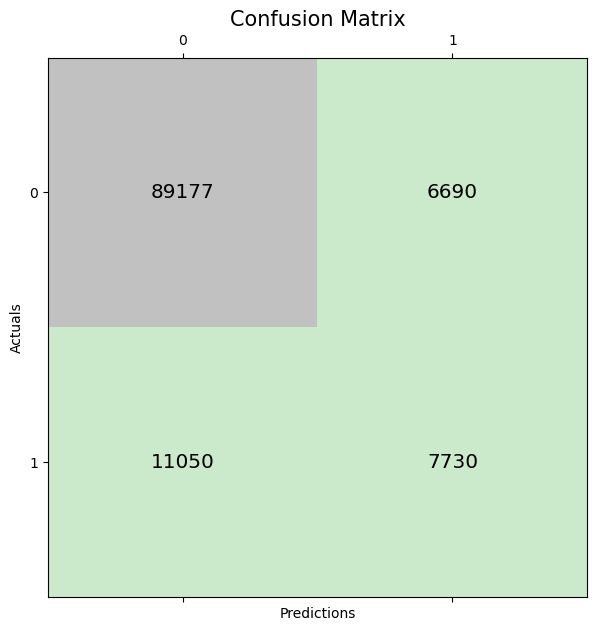

In [26]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=test)

fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
 
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [27]:
precision_original =  round(precision_score(y_test, test), 4)
recall_original = round(recall_score(y_test, test), 4)
F1_score_original =  round(f1_score(y_test, test), 4)
metrics_original = [precision_original, recall_original, F1_score_original]

original = pd.DataFrame(metrics_original)
original.index = ['Precision', 'Recall', 'F1_score']
original.columns = ['Original Dataset']
original['Comments'] = ['Only 54% of the customers targetted are actually interested in renewing their insurance',
                       'Only 41% of the potentially interested customers are being identified',
                       '']
original

,Original Dataset,Comments
Precision,0.5361,Only 54% of the customers targetted are actually interested in renewing their insurance
Recall,0.4116,Only 41% of the potentially interested customers are being identified
F1_score,0.4657,


So, even with a high accuracy of nearly 85%, the model does not perform well in terms of the precision, recall or F1 Score. As we discussed previously, this is due to the algorithm's incapability to distinguish between the minority and majority classes.

In [28]:
from sklearn.metrics import precision_recall_fscore_support

In [30]:
# Evaluate the model using precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, xgb_classifier.predict(X_test))